In [3]:
!pip install bitarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 6.8 MB/s 


In [69]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.utils import murmurhash3_32
from bitarray import bitarray
import math
import csv
import pandas as pd
import string
from tqdm import tqdm

In [5]:
def hashfunc(m):
    p = 1048573
    a = random.randint(1, p)
    b = random.randint(1, p)
    def two_universal_hash(x):
        val = 0
        for c in x:
            val += a * ord(c) + b
        return val % m
    return two_universal_hash

# def hashfunc(m):
#   rand = random.getrandbits(31);
#   return lambda x : (murmurhash3_32(key=x, seed=rand) % m)

In [6]:
data = pd.read_csv("user-ct-test-collection-01.txt", sep="\t")
urllist = data.ClickURL.dropna().unique()

In [7]:
len(urllist)

377870

In [184]:
class BloomFilter ():
  def __init__(self, n, fp_rate, buffer_size):
      # Compute R value (number of bits in the bitmap)
      R = math.ceil(math.log(fp_rate) / math.log(0.618) * n)
      # Round R to the next highest power of 2
      R = 1 << math.ceil(math.log2(R - 1))
      # Compute the number of hash functions
      self.k = round(math.log(2) * R / n)
      self.bitmap = bitarray(R)
      self.bitmap[:] = 0
      self.hashfun_list = [hashfunc(R) for i in range(self.k)]
      self.buffer_size = buffer_size
      self.false_positive_buffer = set()
      self.buffer_url_tracker = []
      self.R = R

  def insert(self, key):
    for i in range(self.k):
      self.bitmap[self.hashfun_list[i](key)] = 1

  def test(self, key):
    if key in self.false_positive_buffer:
        return False
    res = True
    for i in range(self.k):
      if self.bitmap[self.hashfun_list[i](key)] != 1:
        res = False
        break
    if res:
        self.false_positive_buffer.add(key)
        self.buffer_url_tracker.append(key)
        if len(self.false_positive_buffer) > self.buffer_size:
            self.false_positive_buffer.remove(self.buffer_url_tracker.pop(0))
    return res

In [9]:
class Attacher ():
    def __init__(self, bloom_filter : BloomFilter, epsilon, attack_threshold):
        self.bloom_filter = bloom_filter
        self.epsilon = epsilon
        self.attack_threshold = attack_threshold
        self.buffer = set()
        self.positive_queue = []
        self.num_positive_in_queue = 0
        self.records = list()
        self.total_episodes = 0
        self.threshold_reached = False

    def make_url(self):
        if len(self.buffer) < self.attack_threshold or random.random() < self.epsilon:
            return 'http://'.join(random.choices(string.punctuation + string.digits + string.ascii_lowercase, k=random.randint(8, 43))) 
        else:
            if not self.threshold_reached:
                print(self.total_episodes)
                self.threshold_reached = True
            return random.sample(self.buffer, 1)[0]

    def attack(self, num_episodes, plot_interval=100, plot=True):
        for i in range(num_episodes):
            url = self.make_url()
            res = self.bloom_filter.test(url)
            if res:
                self.buffer.add(url)
                self.num_positive_in_queue += 1
                self.positive_queue.append(1)
            else:
                self.positive_queue.append(0)
            if len(self.positive_queue) > plot_interval:
                self.num_positive_in_queue -= self.positive_queue.pop(0)
            if i % plot_interval == 0:
                self.records.append(self.num_positive_in_queue)
            self.total_episodes += 1
        if plot:
            plt.plot(range(0, self.total_episodes, plot_interval), self.records)

In [10]:
malicious_url = random.sample(set(urllist), 10000)
bloom_filter = BloomFilter(10000, 0.01, 20)

In [11]:
for i in range(len(malicious_url)):
    bloom_filter.insert(malicious_url[i])

### Adjust attack threshold

In [ ]:
attacker = Attacher(bloom_filter, 0.01, 60)

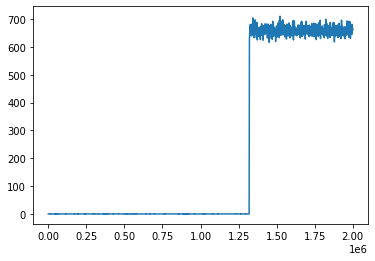

In [ ]:
attacker.attack(500000, plot_interval=1000)

In [ ]:
attacker1 = Attacher(bloom_filter, 0.01, 80)

1915417


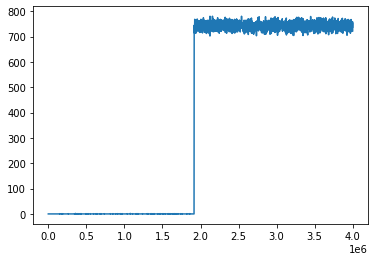

In [ ]:
attacker1.attack(2500000, plot_interval=1000)

In [ ]:
attacker2 = Attacher(bloom_filter, 0.01, 40)

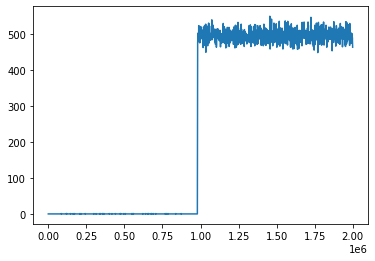

In [ ]:
attacker2.attack(1000000, plot_interval=1000)

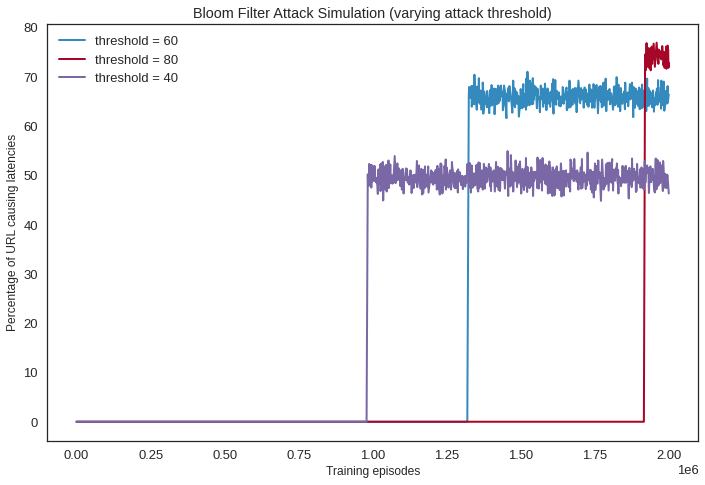

In [ ]:
plt.style.use('seaborn-white')
plt.xlabel("Training episodes")
plt.ylabel("Percentage of URL causing latencies")
plt.title("Bloom Filter Attack Simulation (varying attack threshold)")
plt.plot(range(0, 2000000, 1000), np.asarray(attacker.records)/10, label="threshold = 60")
plt.plot(range(0, 2000000, 1000), np.asarray(attacker1.records)[0:2000]/10, label="threshold = 80")
plt.plot(range(0, 2000000, 1000), np.asarray(attacker2.records)/10, label="threshold = 40")
plt.legend()
plt.savefig("Bloom_Filter_Attack.png", dpi=150)

### Adjust false positive rate

In [ ]:
bloom_filter1 = BloomFilter(10000, 0.1, 20)
bloom_filter2 = BloomFilter(10000, 0.001, 20)
for i in range(len(malicious_url)):
    bloom_filter1.insert(malicious_url[i])
    bloom_filter2.insert(malicious_url[i])

attacker3 = Attacher(bloom_filter1, 0.01, 60)
attacker4 = Attacher(bloom_filter2, 0.01, 60)

40213


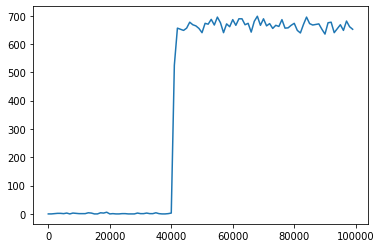

In [ ]:
attacker3.attack(100000, plot_interval=1000)

3704818


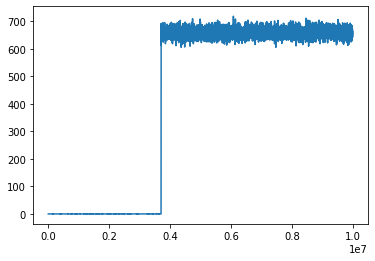

In [ ]:
attacker4.attack(5000000, plot_interval=1000)

### Using Neural Network

In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

In [254]:
class Classifier(nn.Module):

  def __init__(self, input_size=256, mlp_sizes=[256, 256]):
    """Initialize the Neural Network.
    
    Args:
        mlp_sizes: An array of integers. The length of array equals the number
            of hidden layers of the Multi-Layer Perceptron. Each element in the array
            equals the number of nodes in the corresponding layer.
    """
    super().__init__()    
    # input layer
    self.input_layer = nn.Linear(input_size, mlp_sizes[0])
    
    # hidden layers
    self.hidden_layers = nn.ModuleList()
    for k in range(len(mlp_sizes) - 1):
        self.hidden_layers.append(nn.Linear(mlp_sizes[k], mlp_sizes[k+1]))

    # output layer
    self.output_layer = nn.Linear(mlp_sizes[-1], 1)

  def forward(self, x):
    """Implements the forward pass of the Neural Network.
    
    Args:
        x: Input to the Neural Network.
    
    Returns:
        Output of the Neural Network.
    """
    x = torch.relu(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
        x = torch.relu(hidden_layer(x))
    x = torch.sigmoid(self.output_layer(x))
    return x

In [219]:
# Create a training set
urllist_50 = [x for x in urllist if len(x) <= 50]
training_sample = random.sample(urllist_50, 100000)
training_set = [(training_sample[i], 0) if i < len(training_sample)/2 else (training_sample[i], 1) for i in range(len(training_sample))]
len(training_set)

100000

In [220]:
bloom_filter = BloomFilter(50000, 0.01, 20)
for i in range(50000):
    bloom_filter.insert(training_sample[i])

In [221]:
bloom_filter.R

524288

In [223]:
# Add to training set with random inputs
for i in range(20000):
    url = 'http://' + ''.join(random.choices(string.punctuation + string.digits + string.ascii_lowercase, k=random.randint(8, 43)))
    if bloom_filter.test(url):
        training_set.append((url, 1))
    else:
        training_set.append((url, 0))
len(training_set)

120000

In [237]:
character_set = string.punctuation + string.digits + string.ascii_lowercase
character_dict = dict()
for i in range(len(character_set)):
    character_dict[character_set[i]] = i
character_dict[' '] = len(character_set)
len(character_dict)

69

In [224]:
random.shuffle(training_set)

In [225]:
training_set

[('http://www.bigboystoyz.com', 1),
 ('http://p9$@<c2crcta"_]]-|#gkb\'3c\'w;cd((', 0),
 ('http://www.chocosphere.com', 1),
 ('http://>l9<a~]\\@qmo|7x(zhb4x?+"v6w=,:hlb5+', 0),
 ('http://biblenotes.homestead.com', 0),
 ('http://www.safehorizon.org', 0),
 ('http://www.janetlynn.com', 0),
 ('http://www.asiafood.org', 1),
 ('http://edgewoodprop.com', 0),
 ('http://schools.detroit.k12.mi.us', 0),
 ('http://www.nazdar.com', 1),
 ('http://www.supersphere.com', 0),
 ('http://www.lakiff.com', 0),
 ('http://#y6n.<m!&)s3{g-+-+&1/k2"!p`', 0),
 ('http://royalhawaii.com', 0),
 ('http://www.lakeviewmemorialpark.com', 1),
 ('http://www.grayandsons.com', 0),
 ('http://www.bizwebchicago.com', 1),
 ('http://www.taveloptical.com', 1),
 ('http://@wp,;{/.~gp', 0),
 ('http://www.alexiadesigns.com', 0),
 ("http://~i285@^g*'<r#q}xop=%'_q/&`6ej/", 0),
 ('https://www.rockauto.com/dbphp/mak,dodge,1988', 1),
 ('http://www.endowsec.com', 1),
 ('http://reviewjournal.lawinfo.com', 1),
 ('http://|~8\\n?{n0(%]$j0rq@,]g

In [247]:
def toClassifierInput(url, input_size=256):
    res = np.zeros(input_size)
    for i in range(len(url)):
        res[ord(url[i])] += 1
    return res

In [257]:
class URLClassifier():
    def __init__(self, learning_rate=0.001, hidden_layer_sizes=[256, 256]):
        self.learning_rate = learning_rate
        self.classifier = Classifier(mlp_sizes=hidden_layer_sizes)
        self.classifier = self.classifier.float()
        self.optimizer = optim.Adam(self.classifier.parameters(), lr=self.learning_rate)
        self.loss_list = list()

    def train(self, training_set):
        for step in range(len(training_set)):
            input = torch.from_numpy(toClassifierInput(training_set[step][0]))
            output = self.classifier(input.float())

            self.optimizer.zero_grad()
            loss = (output - torch.tensor(training_set[step][1]))**2
            loss.backward()
            self.optimizer.step()

            self.loss_list.append(loss.detach().numpy())

            if step % 1000 == 0:
                print("The average loss at step", step, "is", np.mean(self.loss_list))
                self.loss_list.clear()

In [258]:
url_classifier = URLClassifier(hidden_layer_sizes=[256, 256])
url_classifier.train(training_set[0:10000])

The average loss at step 0 is 0.26621717
The average loss at step 1000 is 0.22810055
The average loss at step 2000 is 0.21481423
The average loss at step 3000 is 0.22250737
The average loss at step 4000 is 0.22415513
The average loss at step 5000 is 0.22430223
The average loss at step 6000 is 0.2202229
The average loss at step 7000 is 0.21338892
The average loss at step 8000 is 0.2249418
The average loss at step 9000 is 0.21648538


In [256]:
url_classifier.classifier(torch.from_numpy(toClassifierInput("http://www.bartle.disted.camosun.bc.ca")).float())

tensor([0.5035], grad_fn=<SigmoidBackward0>)